In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
from matplotlib.patches import Ellipse
from matplotlib import gridspec
import scienceplots
import warnings
import h5py

import ppxf.ppxf_util as util

from astropy.utils.exceptions import AstropyWarning
import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting,polynomial
import astropy.modeling as modeling
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel

import sep
from photutils.aperture import EllipticalAperture, SkyEllipticalAperture
from photutils.psf import PSFPhotometry,FittableImageModel,IterativePSFPhotometry
from photutils.detection import DAOStarFinder

import os, sys, glob, pdb
os.environ["SPS_HOME"]="/disk/bifrost/yuanze/software/fsps"

from importlib import reload
from reproject import reproject_interp
from regions import Regions
import linetools

import fsps
import sedpy
import prospect
import emcee
import dynesty

In [4]:
ccgs = constants.c.to(u.cm/u.s).value
ckm = constants.c.to(u.km/u.s).value
phot_result={}

## Do PSF photometry for Spitzer IRAC

In [2]:
sourcename="UGC2369_1"
field="UGC2369"
KBSSpath="/disk/bifrost/yuanze/KBSS"
multiAGNpath="/disk/bifrost/yuanze/multiAGN"



stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")
datatype="spitzer"
inst="IRAC/ch4"
filter="f435w"
if datatype == "hst":
    datapath=glob.glob(multiAGNpath+"/"+field+"/"+datatype+f"/hst_*{filter:s}*")[0]
    fprefix = datapath.split("/")[-1]
    fname = datapath+"/"+fprefix+"_drc.fits"
    outname = datapath+"/"+fprefix
    hdu = fits.open(outname+'_cutimg.fits')
    cfac=1.
elif datatype == "spitzer":
    datapath=glob.glob(multiAGNpath+"/"+field+"/"+datatype+"/"+inst+f"/pbcd/SPITZER_*maic.fits")[0]
    fprefix = datapath.split("/")[-1].split(".")[0]
    fname = datapath
    outname = multiAGNpath+"/"+field+"/"+datatype+"/"+inst+f"/pbcd/{fprefix:s}"
    hdu = fits.open(outname+'_cutimg.fits')
    pix_scale=hdu[0].header["PXSCAL2"]
    print("pix_scale=",pix_scale)
    #cfac=2.350443e-5*pix_scale**2/1e23 # MJy/Sr to erg/s/cm^2/Hz/pixel
    cfacJy=2.350443e-5*pix_scale**2
#conver={"ch2":0.1382,"ch4":0.2026}
#dataname="q1549_irac_"+subtype+"_mosaic.fits"
#dataname="Q1549_F606W_075_drc_sci.fits"
sentry = stab[stab["Field"]==field]

ra = np.mean(sentry["RA"].value)
dec = np.mean(sentry["Dec"].value)
sc = SkyCoord(ra=ra,dec=dec,unit="deg")

#datapath=KBSSpath+"/"+field+"/"+datatype+"/"+dataname
#fname = datapath





imdata = hdu[0].data
#sky_mean, sky_median, sky_std = sigma_clipped_stats(imdata, sigma=3)

error= fits.open(outname+'_cutsigma.fits')[0].data
mask= fits.open(outname+'_cutmask.fits')[0].data
psfim = fits.open(outname+"_epsf.fits")[0].data
#img = IM.image(fname,hdu=0)
psf_model = FittableImageModel(psfim)
wcsinfo=WCS(hdu[0].header)

pix_scale= 0.6000012


In [163]:
from photutils.background import LocalBackground, MMMBackground
from astropy.table import QTable

bkgstat = MMMBackground()
localbkg_estimator = LocalBackground(20, 30, bkgstat)

fit_shape = [5,5]
finder = DAOStarFinder(6.0, 2.0)
#Do iterative PSF photometry
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,localbkg_estimator=localbkg_estimator,
                        aperture_radius=4,fitter_maxiters=500)

init_params = QTable()

xini=[]
yini=[]
for ind,RA in enumerate(sentry["RA"].value):
    sc = SkyCoord(ra=RA, dec=sentry["Dec"].value[ind], unit='deg',frame="icrs", equinox='J2000')
    s_coord=wcsinfo.world_to_pixel(sc)
    xini.append(s_coord[0].flatten()[0])
    yini.append(s_coord[1].flatten()[0])
init_params['x'] = xini
init_params['y'] = yini


In [164]:
phot = psfphot(imdata, error=error,mask=mask.astype("bool"),init_params=init_params)

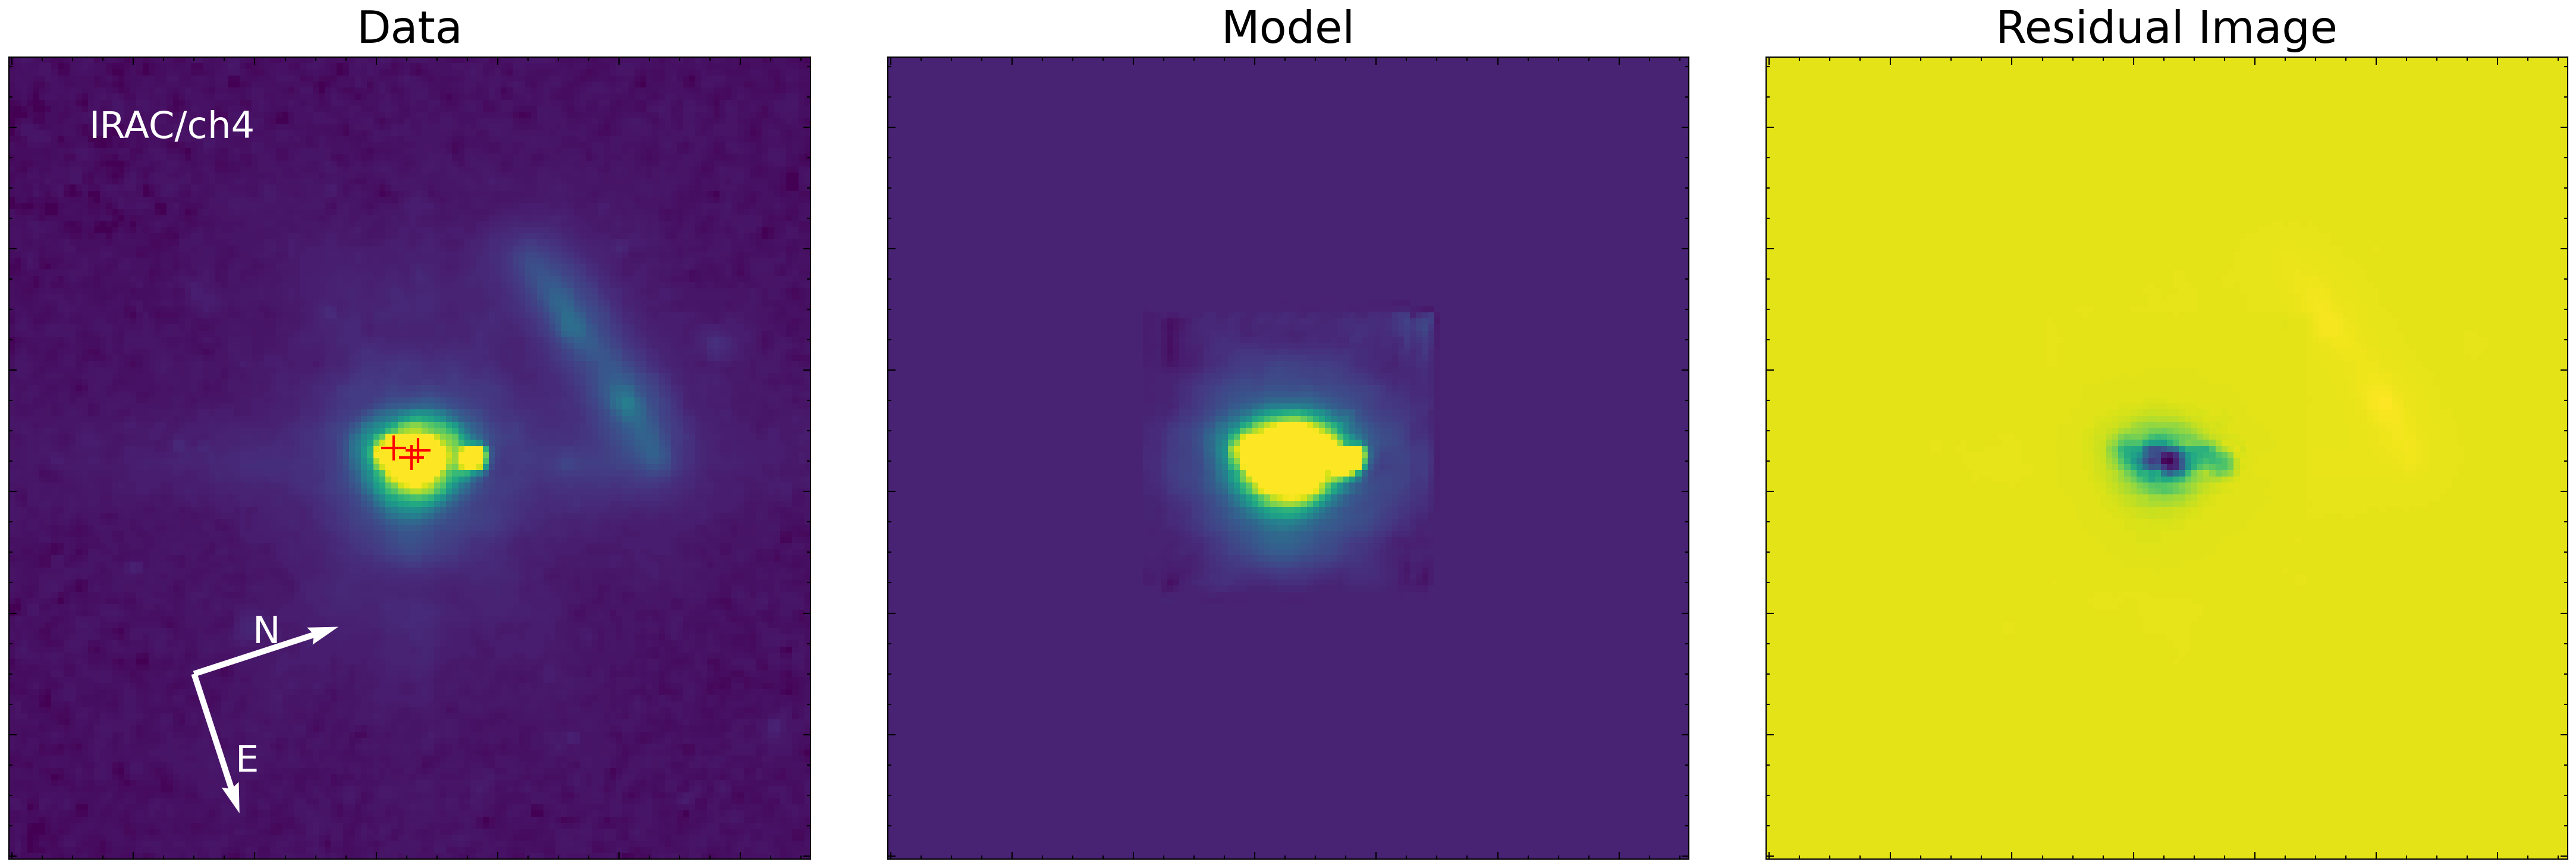

In [166]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})


resid = psfphot.make_residual_image(imdata, (49, 49))
resid -= np.mean(phot["local_bkg"])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),dpi=300)
norm = vis.simple_norm(imdata, 'sqrt', percent=99)
ax[0].imshow(imdata, origin='lower', norm=norm)
ax[1].imshow(imdata - resid, origin='lower', norm=norm)
im = ax[2].imshow(resid, origin='lower')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')


x0, y0 = 30, 30
arrow_length = 15/3600

# Convert pixel coordinates to sky coordinates (RA, Dec)
sky_coords = wcsinfo.pixel_to_world(x0, y0)
ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

# Define the end points of the arrows in pixel coordinates
north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
east_end = wcsinfo.world_to_pixel_values(ra - arrow_length, dec)


# Calculate the direction vectors for the arrows
north_vector = [north_end[0] - x0, north_end[1] - y0]
east_vector = [east_end[0] - x0, east_end[1] - y0]

# Plot the North arrow
ax[0].quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='w')
ax[0].text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='w', ha='center', va='bottom')

# Plot the East arrow
ax[0].quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='w')
ax[0].text(x0 + east_vector[0]/2+5, y0 + east_vector[1]/2, 'E', color='w', ha='center', va='top')
ax[0].text(0.1,0.9,"{}".format(inst),transform=ax[0].transAxes,color="w")

for ent in phot["x_fit","y_fit"]:
    ax[0].plot(ent["x_fit"], ent["y_fit"],"+",c="r",ms=10,lw=0.1)
for axx in ax:
    axx.set_xticklabels([])
    axx.set_yticklabels([])
#fig.savefig(multiAGNpath+"/"+field+"/fig/{}_{}_{}.pdf".format(datatype,inst.split("/")[0],inst.split("/")[1]))
plt.tight_layout()

## Save photometric measurement to file

In [158]:
mag=-2.5*np.log10(phot["flux_fit"].value*2.350443e-5*pix_scale**2/3631) # apparent magnitude
mag_err=2.5*phot["flux_err"].value*2.350443e-5*pix_scale**2/3631/(phot["flux_fit"].value*2.350443e-5*pix_scale**2/3631*np.log(10))
phot_result[inst]=[mag,mag_err]
print(phot_result[inst])

[array([11.39470111, 11.18452793, 10.93209804]), array([0.00376399, 0.00398747, 0.00306793])]


In [142]:
IRcorr=phot["flux_fit"]*cfac*constants.c.to(u.micron/u.s).value/8*Planck18.luminosity_distance(0.0315).to(u.cm).value**2*4*np.pi*0.011

In [156]:
phot.

id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,group_size,qfit,cfit,flags
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64
1,1,5.224555506695243,63.34615369559498,66.01577743788027,6789.468306776907,62.84109987114977,67.14350061763302,11876.592203889451,0.013958234164369194,0.007548865204651033,41.17331031960013,25,1,0.01467664170467648,0.00035058520792194213,0
2,2,5.210292462702398,66.13473808211813,63.266424420477406,7664.252552483785,65.85354219106723,65.60893732150946,14413.223277069766,0.013891053664968523,0.007741832681698135,52.93398699702431,25,1,0.019235250034395922,-0.002328098945979472,0
3,3,5.2326195531466215,67.69867494945207,66.21425185543497,8368.260342421203,66.84900968969572,66.78223810171365,18185.827716934324,0.009284090590474801,0.00790683975933093,51.387145676375496,25,1,0.007305849477831636,0.0001936134117925294,0


# SED fitting with prospector

## Build observations for fitting

In [262]:
obj=3


def build_obs(snr=10, ldist=10.0, **extras):
    """Build a dictionary of observational data.  In this example 
    the data consist of photometry for UGC 2369
    
    :param snr:
        The S/N assumed to the photometry
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}

    # These are the names of the relevant filters, 
    # in the same order as the photometric data (see below)
    #galex = ['galex_FUV', 'galex_NUV']
    spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]
    #sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    filternames = spitzer
    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    #M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86, 
    #                 -14.94, -14.09, -13.62, -13.23, -12.78])
    #dm = 25 + 5.0 * np.log10(ldist)
    #mags = M_AB + dm
    #1 maggie is the flux density in Janskys divided by 3631
    obs["maggies"] = None#10**(-0.4*mags)

    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
    obs["maggies_unc"] = None#(1./snr) * obs["maggies"]

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we mask the spitzer bands.
    obs["phot_mask"] = None#np.array(['spitzer' in f.name for f in obs["filters"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = None#np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    specinstru="MUSE"#,"OSIRIS"]
    
    datapath=os.path.join(multiAGNpath,field)
    path_out = os.path.join(datapath, '{}_1D'.format(specinstru))
    
    data = np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_obj{}.txt".format(specinstru,obj)))
    lam = data[:,0]  # OBS wavelength [A]
    flux = data[:,1]*1e-20  # OBS flux [erg/s/cm^2/A]
    err = data[:,2]*1e-20  # 1 sigma error
    
    specmaggies = 3.33564095e4*flux*lam**2 / 3631
    specunc = 3.33564095e4*err*lam**2 / 3631
    
    obs["wavelength"] = lam
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = specmaggies
    # (spectral uncertainties are given here)
    obs['unc'] = specunc
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    mask0 = util.determine_mask(np.log(lam), [lam[0],lam[-1]], 0.0317, width=1000)
    mask = (specmaggies>0.001*np.median(specmaggies)) &mask0 &((lam<5400)| (lam>6120))
    
    obs['mask'] = mask

    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    return obs

def build_model(object_redshift=None, ldist=10.0, fixed_metallicity=None,
                add_duste=False,add_neb=False, add_dispersion=False,**extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SpecModel,SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["parametric_sfh"]
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = sentry["z_sys"][obj-1]
    model_params["dust2"]["init"] = 0.05
    model_params["logzsol"]["init"] = -0.5
    model_params["tage"]["init"] = 13.
    model_params["mass"]["init"] = 1e10
    
    
    # These are dwarf galaxies, so lets also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e10)
    
    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e6
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
    if add_neb:
        # Add nebular emission
        model_params.update(TemplateLibrary["nebular"])
        model_params["gas_logu"]['isfree'] = False
        model_params["gas_logu"]["init"] = -2.92

    if add_dispersion:
        model_params["sigma_smooth"] = {"N": 1, "isfree": True, "init": 100., "units":"km/s"}
        model_params["sigma_smooth"]["prior"] = priors.TopHat(mini=50, maxi=200)
        #model_params["gas_logu"]["prior"] = priors.LogUniform(mini=-4, maxi=0)
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps


In [289]:
run_params = {}

run_params["snr"] = 10.0
run_params["ldist"] = Planck18.luminosity_distance(sentry["z_sys"][obj-1]).to(u.Mpc).value
run_params["zcontinuous"] = 1
run_params["object_redshift"] = None#sentry["z_sys"][obj-1]  letting redshift free to vary,0.0317
run_params["fixed_metallicity"] = 0.0 #fix metalicity to solar value
run_params["add_duste"] = False
run_params["add_neb"] = True
run_params["add_dispersion"] = True
#=== smoothing model spectrum to fit the observed spectrum
#run_params["sigma_smooth"] = None # removing the regular constant velocity smoothing
#run_params["smoothtype"] = "lsf" # LSF smoothing

## Build the observation

In [290]:
obs = build_obs(**run_params)

In [291]:
model = build_model(**run_params)
sps = build_sps(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=1000000.0,maxi=10000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=100.0)
  sigma_smooth: <class 'prospect.models.priors.TopHat'>(mini=50,maxi=200)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.0317] 
  logzsol: [0.] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  lumdist: [143.83240368] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f22dcbfa5f0>
  gas_logu: [-2.92] 

Initial free parameter vector theta:
  [1.0e+10 5.0e-02 1.3e+01 1.0e+00 1.0e+02]

Initial parameter dictionary:
{'zred': array([0.0317]), 'mass': array([1.e+10]), 'logzsol': array([0.]), 'dus

Text(0.5, 1.0, 'mass=1.00e+10,dust2=5.00e-02,tage=1.30e+01,tau=1.00e+00,sigma_smooth=1.00e+02')

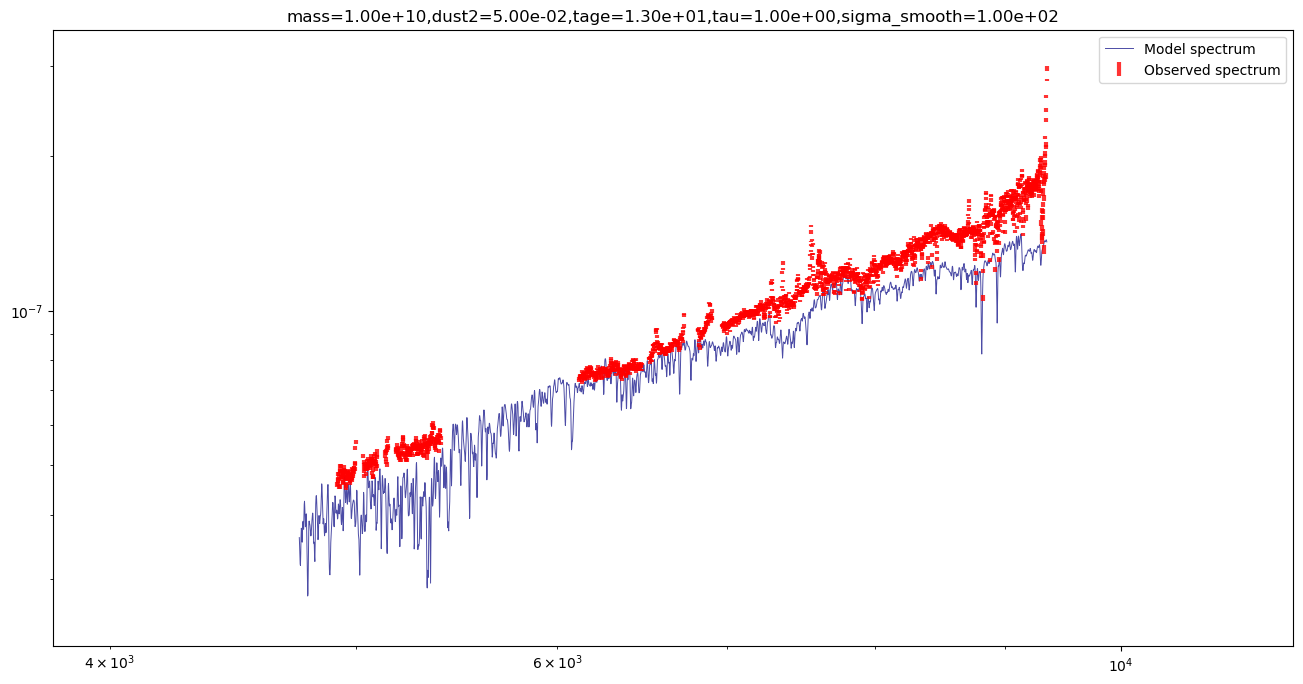

In [203]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.predict(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={:.2e}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting

#o_spec=obs["spectrum"]

if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

xmin, xmax = np.min(wspec)*0.8, np.max(wspec)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
plt.figure(figsize=(16,8))

# plot model + data
plt.loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
plt.errorbar(wspec[obs['mask']], obs['spectrum'][obs['mask']], yerr=obs['unc'][obs['mask']], 
         label='Observed spectrum',
          markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.legend(loc="best")
plt.title(title_text)

## Define likelihood function

In [232]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.fitting import fit_model,lnprobfn

verbose = False
run_params["verbose"] = verbose

In [205]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    """
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return np.zeros(model.ndim) - np.infty

    # Generate mean model
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return np.zeros(model.ndim) - np.infty

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])



In [7]:
# Here we will run all our building functions

obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# we are using
print(sps.ssp.libraries)

NameError: name 'build_obs' is not defined

In [207]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 6

#output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

Done optmization in 95.63307356834412s


[2.12948016e+09 7.52899919e-01 6.33260706e+00 1.13100695e+01
 1.99999953e+02]
1
[2.12948016e+09 7.52899919e-01 6.33260706e+00 1.13100695e+01
 1.99999953e+02]


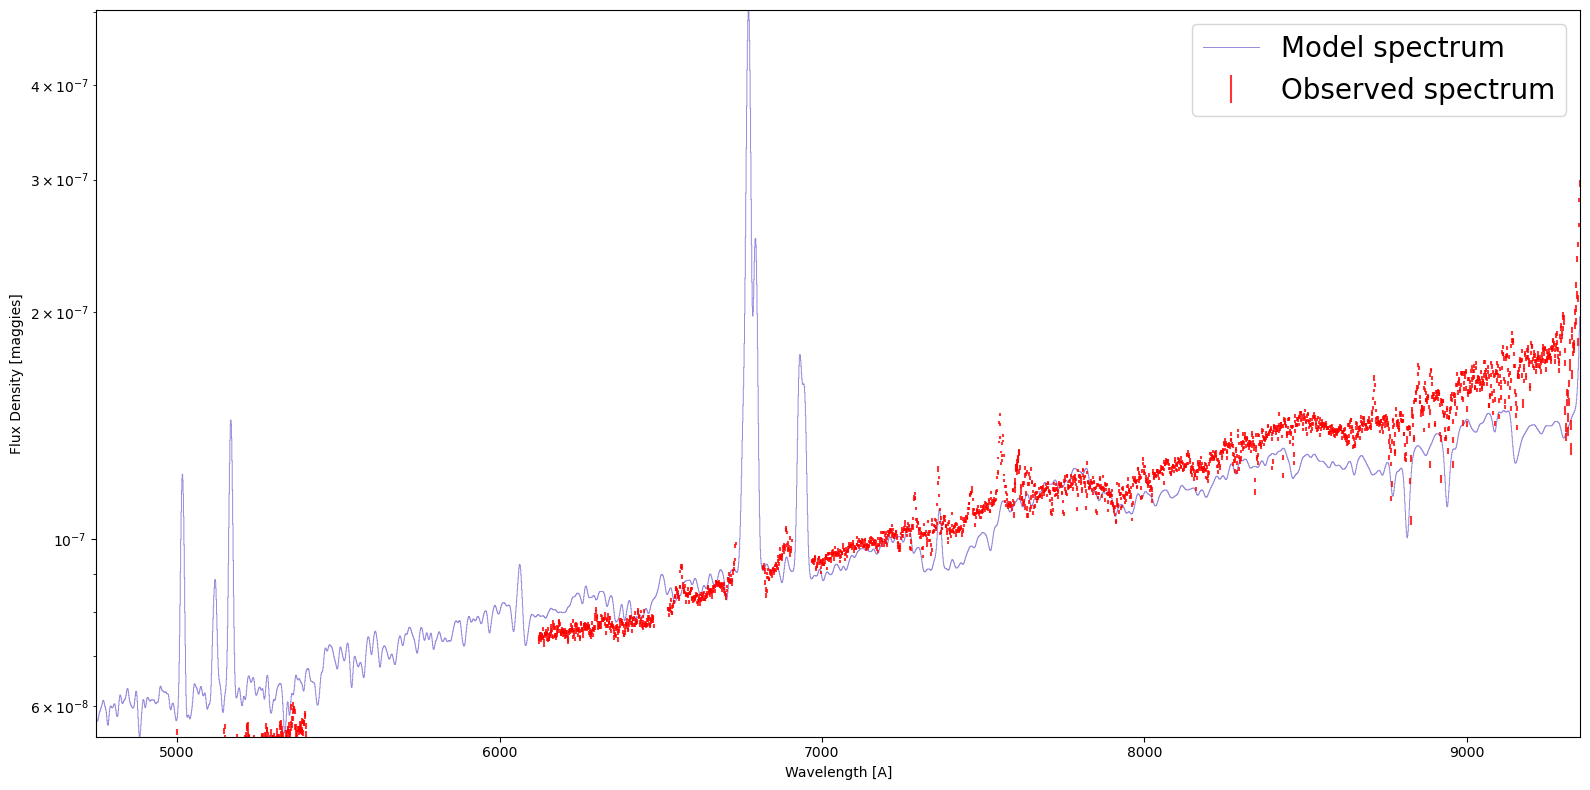

In [209]:


print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)

# generate model
prediction = model.predict(theta_best, obs=obs, sps=sps)
#prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

plt.figure(figsize=(16,8))

# plot Data, best fit model, and old models
#plt.loglog(wspec, initial_spec, label='Old model spectrum',
#       lw=0.7, color='gray', alpha=0.5)

plt.step(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)

plt.errorbar(wspec[obs['mask']], obs['spectrum'][obs['mask']], yerr=obs['unc'][obs['mask']], 
         label='Observed spectrum',
          markersize=10, alpha=0.8, ls='',
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filter transmission curves
'''
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
'''
# Prettify
xmin=np.min(wspec)
xmax=np.max(wspec)
ymin=np.min(pspec)
ymax=np.max(pspec)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
#plt.xlim([7000, 9000])
plt.ylim([ymin, ymax])
plt.yscale("log")
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

In [233]:
run_params["dynesty"] = True
run_params["optmization"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e6)


#output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

done dynesty in 14986.44413638115s


In [324]:
from prospect.io import write_results as writer
import importlib
importlib.reload(writer)
hfile = "test_no_line_dynesty_mcmc.h5"
'''
def encode_strings(data):
    """Convert Unicode strings to byte strings and handle NoneType values."""
    if isinstance(data, dict):
        return {k: encode_strings(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [encode_strings(v) for v in data]
    elif isinstance(data, np.ndarray):
        if data.dtype.kind == 'U':  # Unicode strings
            return data.astype('S')  # Convert to byte strings
        elif data.dtype.kind == 'O':  # Object type, may contain mixed types
            return np.array([encode_strings(x) for x in data])
        else:
            return data
    elif isinstance(data, str):
        return data.encode('utf-8')  # Convert string to bytes
    elif data is None:
        return np.nan  # Convert NoneType to NaN for numerical arrays
    else:
        return data

run_params = encode_strings(run_params)
model = encode_strings(model)
obs = encode_strings(obs)
eoutput = encode_strings(output)
'''
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


## Read result from prospector run

In [3]:
import prospect.io.read_results as reader
results_type = "dynesty"
ttag=1728140879
obj=3
isoc="mist"
stelib="miles"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
#result, obs, _ = reader.results_from("test_no_line_{}_mcmc.h5".format(results_type), dangerous=False)
result, obs, _ = reader.results_from(multiAGNpath+"/fitting/obj{}_{}_{}_{}_{}.h5".format(obj,ttag,results_type,isoc,stelib), dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


In [4]:
import h5py
def optresultlist_to_ndarray(results): 
    npar, nout = len(results[0].x), len(results[0].fun)
    dt = [("success", bool), ("message", "U50"), ("nfev", int),
          ("x", (float, npar)), ("fun", (float, nout))]
    out = np.zeros(len(results), dtype=np.dtype(dt))
    for i, r in enumerate(results):
        for f in out.dtype.names:
            out[i][f] = r[f]
    return out
hf = h5py.File("test_file", "a")
out=optresultlist_to_ndarray(output["optimization"][0])

mgroup = hf.create_group('optimization')
mdat = mgroup.create_dataset('optimizer_results', data=out)

NameError: name 'output' is not defined

In [9]:
model

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  logmass: <class 'prospect.models.priors.TopHat'>(mini=8,maxi=10)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0. 0. 0. 0. 0. 0.],scale=[0.3 0.3 0.3 0.3 0.3 0.3 0.3],df=[2. 2. 2. 2. 2. 2. 2.])

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.0312] 
  mass: [1000000.] <function logsfr_ratios_to_masses at 0x7f7fc9b0ad40>
  logzsol: [0.] 
  dust2: [3.08] 
  sfh: [3] 
  imf_type: [1] 
  dust_type: [2] 
  agebins: [[ 0.          6.4772    ]
 [ 6.4772      7.        ]
 [ 7.          7.6132279 ]
 [ 7.6132279   8.2264558 ]
 [ 8.2264558   8.8396837 ]
 [ 8.8396837   9.45291159]
 [ 9.45291159 10.06613949]
 [10.06613949 10.13672057]] 
  lumdist: [141.51197841] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f7fc9ad2950>
  gas_logu: [-2.92] 
  smoothtype: ['vel'] 
  ff

['logmass', 'logsfr_ratios_1', 'logsfr_ratios_2', 'logsfr_ratios_3', 'logsfr_ratios_4', 'logsfr_ratios_5', 'logsfr_ratios_6', 'logsfr_ratios_7']
[ 9.70571791 -6.69596839  5.76501899 -2.58567865 -3.0645263   7.57703565
  0.04926667 -0.09079584]


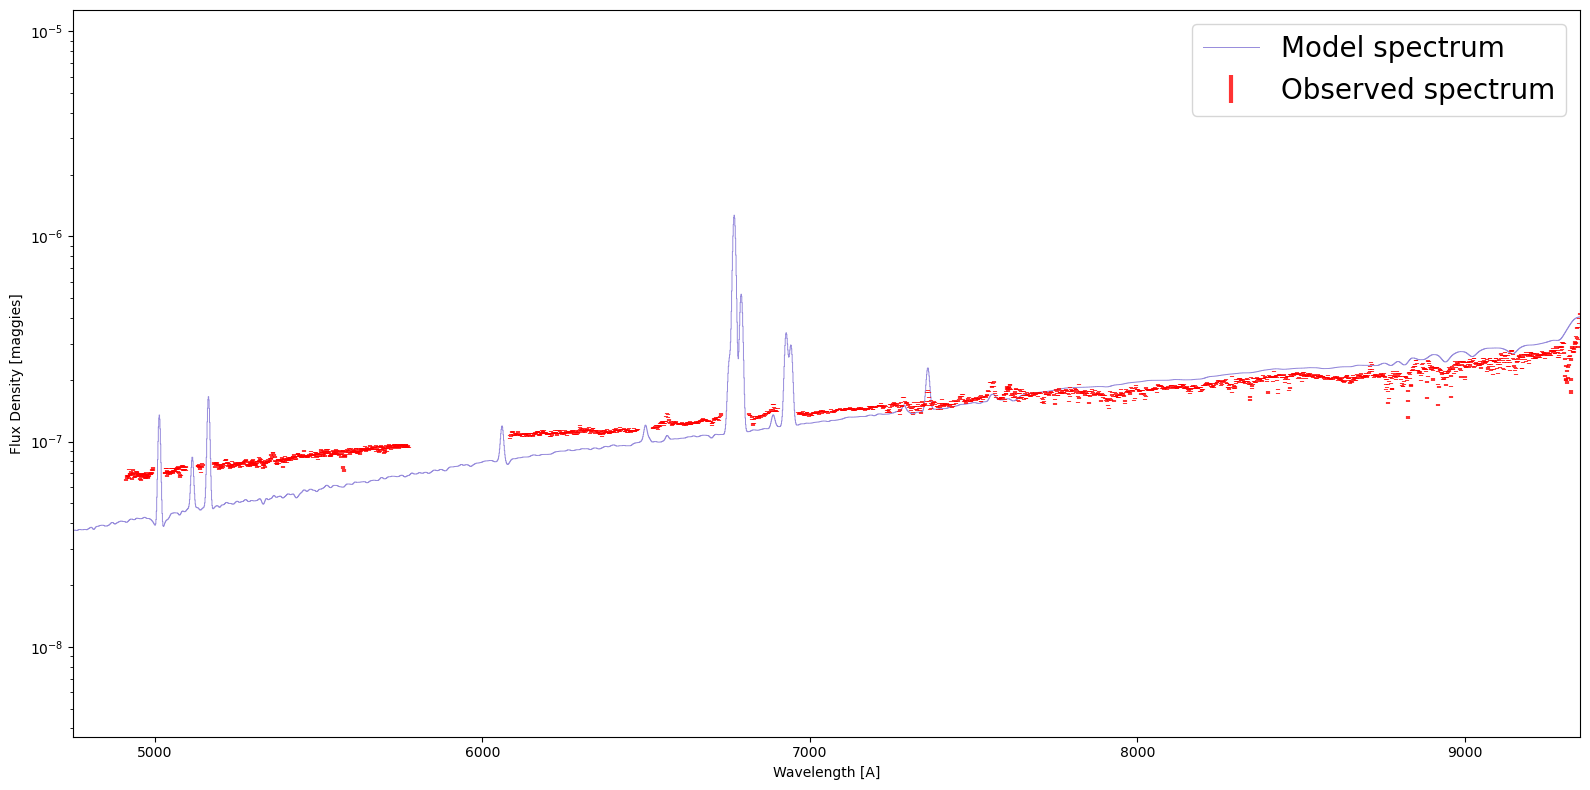

In [8]:
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
#model=mpi_emcee.build_model(**result['run_params'])
sys.path.append(multiAGNpath+'/fitting')
import mpi_dynesty_nonpara as mymodule
reload(mymodule)
from prospect.plotting.utils import sample_posterior
theta = sample_posterior(result["chain"], weights=result.get("weights", None), nsample=100)

model = mymodule.build_model(**result["run_params"])
sps = mymodule.build_sps(**result["run_params"])

obs=result["obs"]
wspec=obs["wavelength"]
theta_labels=result['theta_labels']
theta_best=result["bestfit"]['parameter']#np.mean(result["chain"],axis=(0,1))
print(theta_labels)
print(theta_best)
# generate model

#prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = result['bestfit']['spectrum'], result['bestfit']['photometry'],result['bestfit']['mfrac']

plt.figure(figsize=(16,8))

# plot Data, best fit model, and old models

#for stheta in theta:
#    sspec, sphot, smfrac = model.predict(stheta, obs=result['obs'], sps=sps)
#    plt.plot(wspec, sspec, '-',alpha=0.1)

plt.step(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
plt.errorbar(wspec[obs['mask']], obs['spectrum'][obs['mask']], yerr=obs['unc'][obs['mask']], 
#plt.errorbar(wspec, obs['spectrum'], yerr=obs['unc'], 
         label='Observed spectrum', ecolor='red', 
         ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

'''
# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
'''
# Prettify
xmin=np.min(wspec)
xmax=np.max(wspec)
ymin=np.min(pspec)
ymax=np.max(pspec)
#plt.axvline(5600*(1+0.031))
#plt.axvline(5900*(1+0.031))
plt.yscale("log")
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10, ymax*10])
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

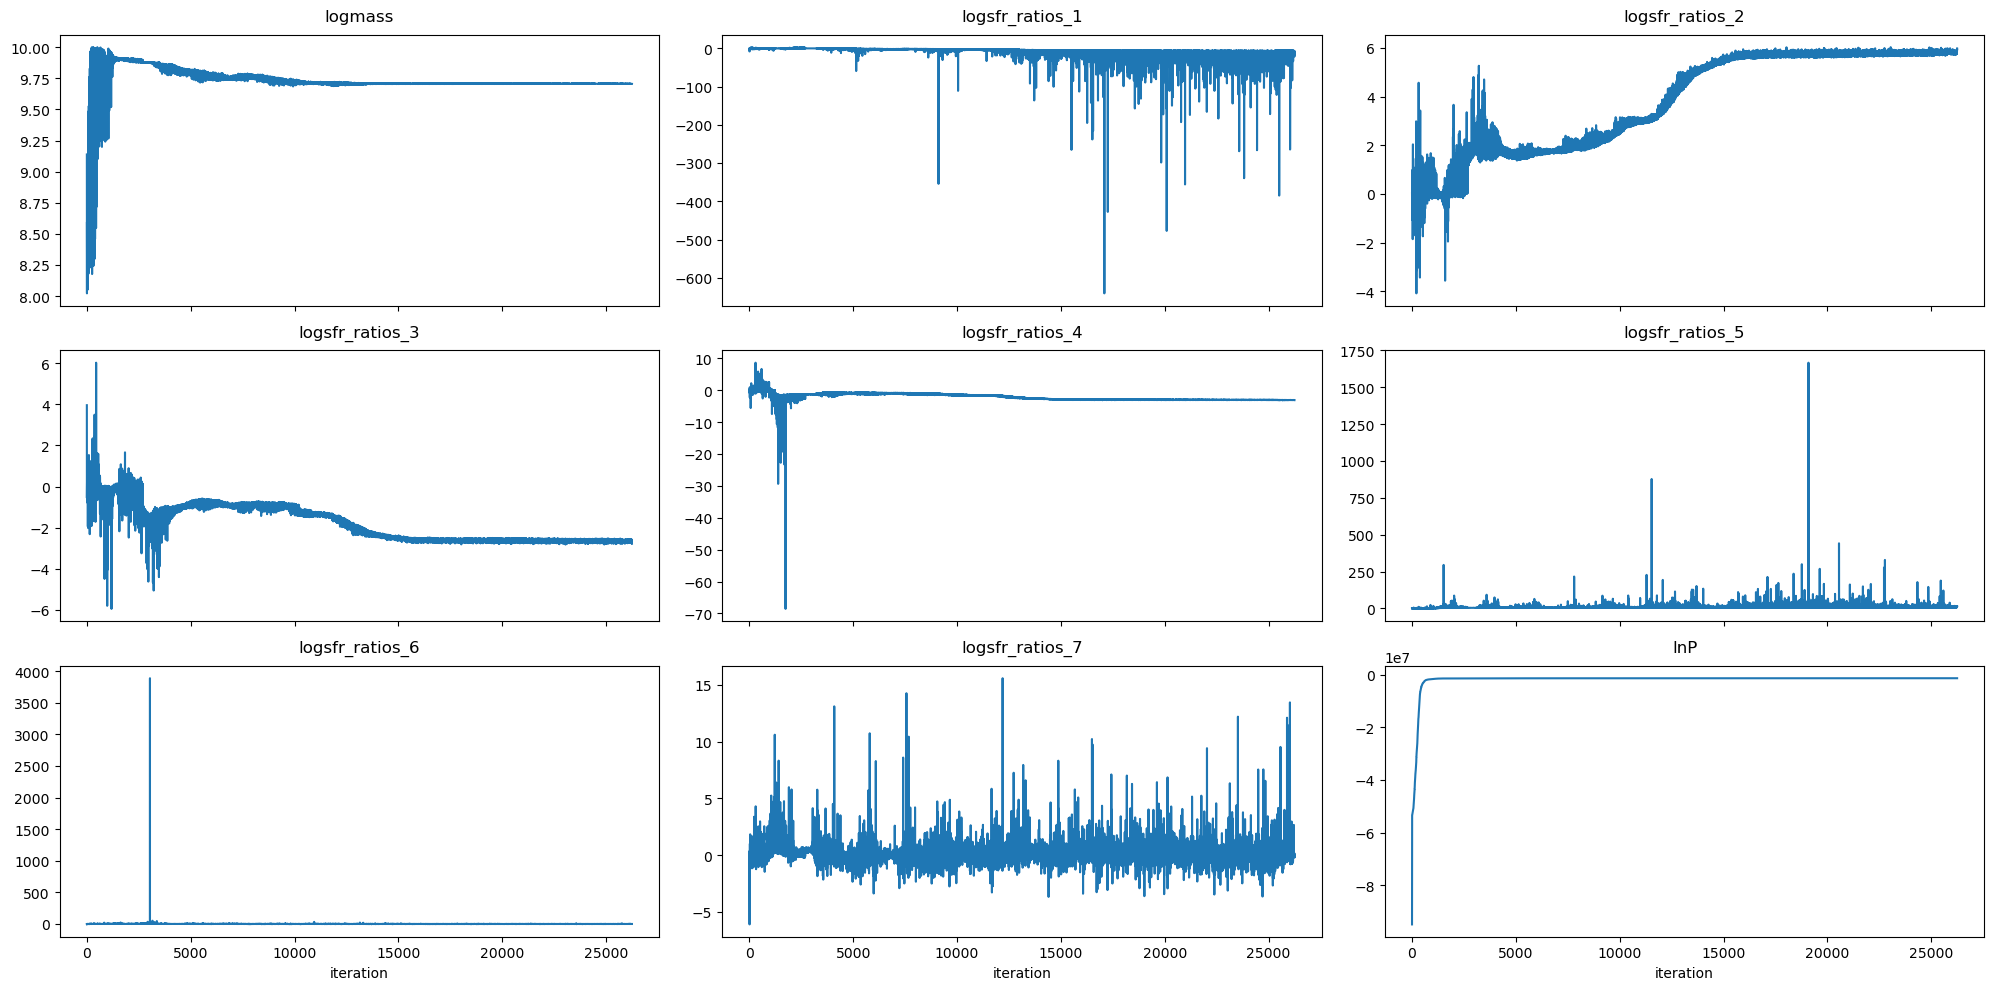

In [6]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


MAP value: [-9.98407830e-04  1.88049873e+00  9.45521366e+00 -6.71547236e+00
  1.08296810e+00 -1.13085487e-01 -5.28296210e-01  1.73008560e+00
  1.43481092e-01 -1.63351451e+00  6.61304797e+01]


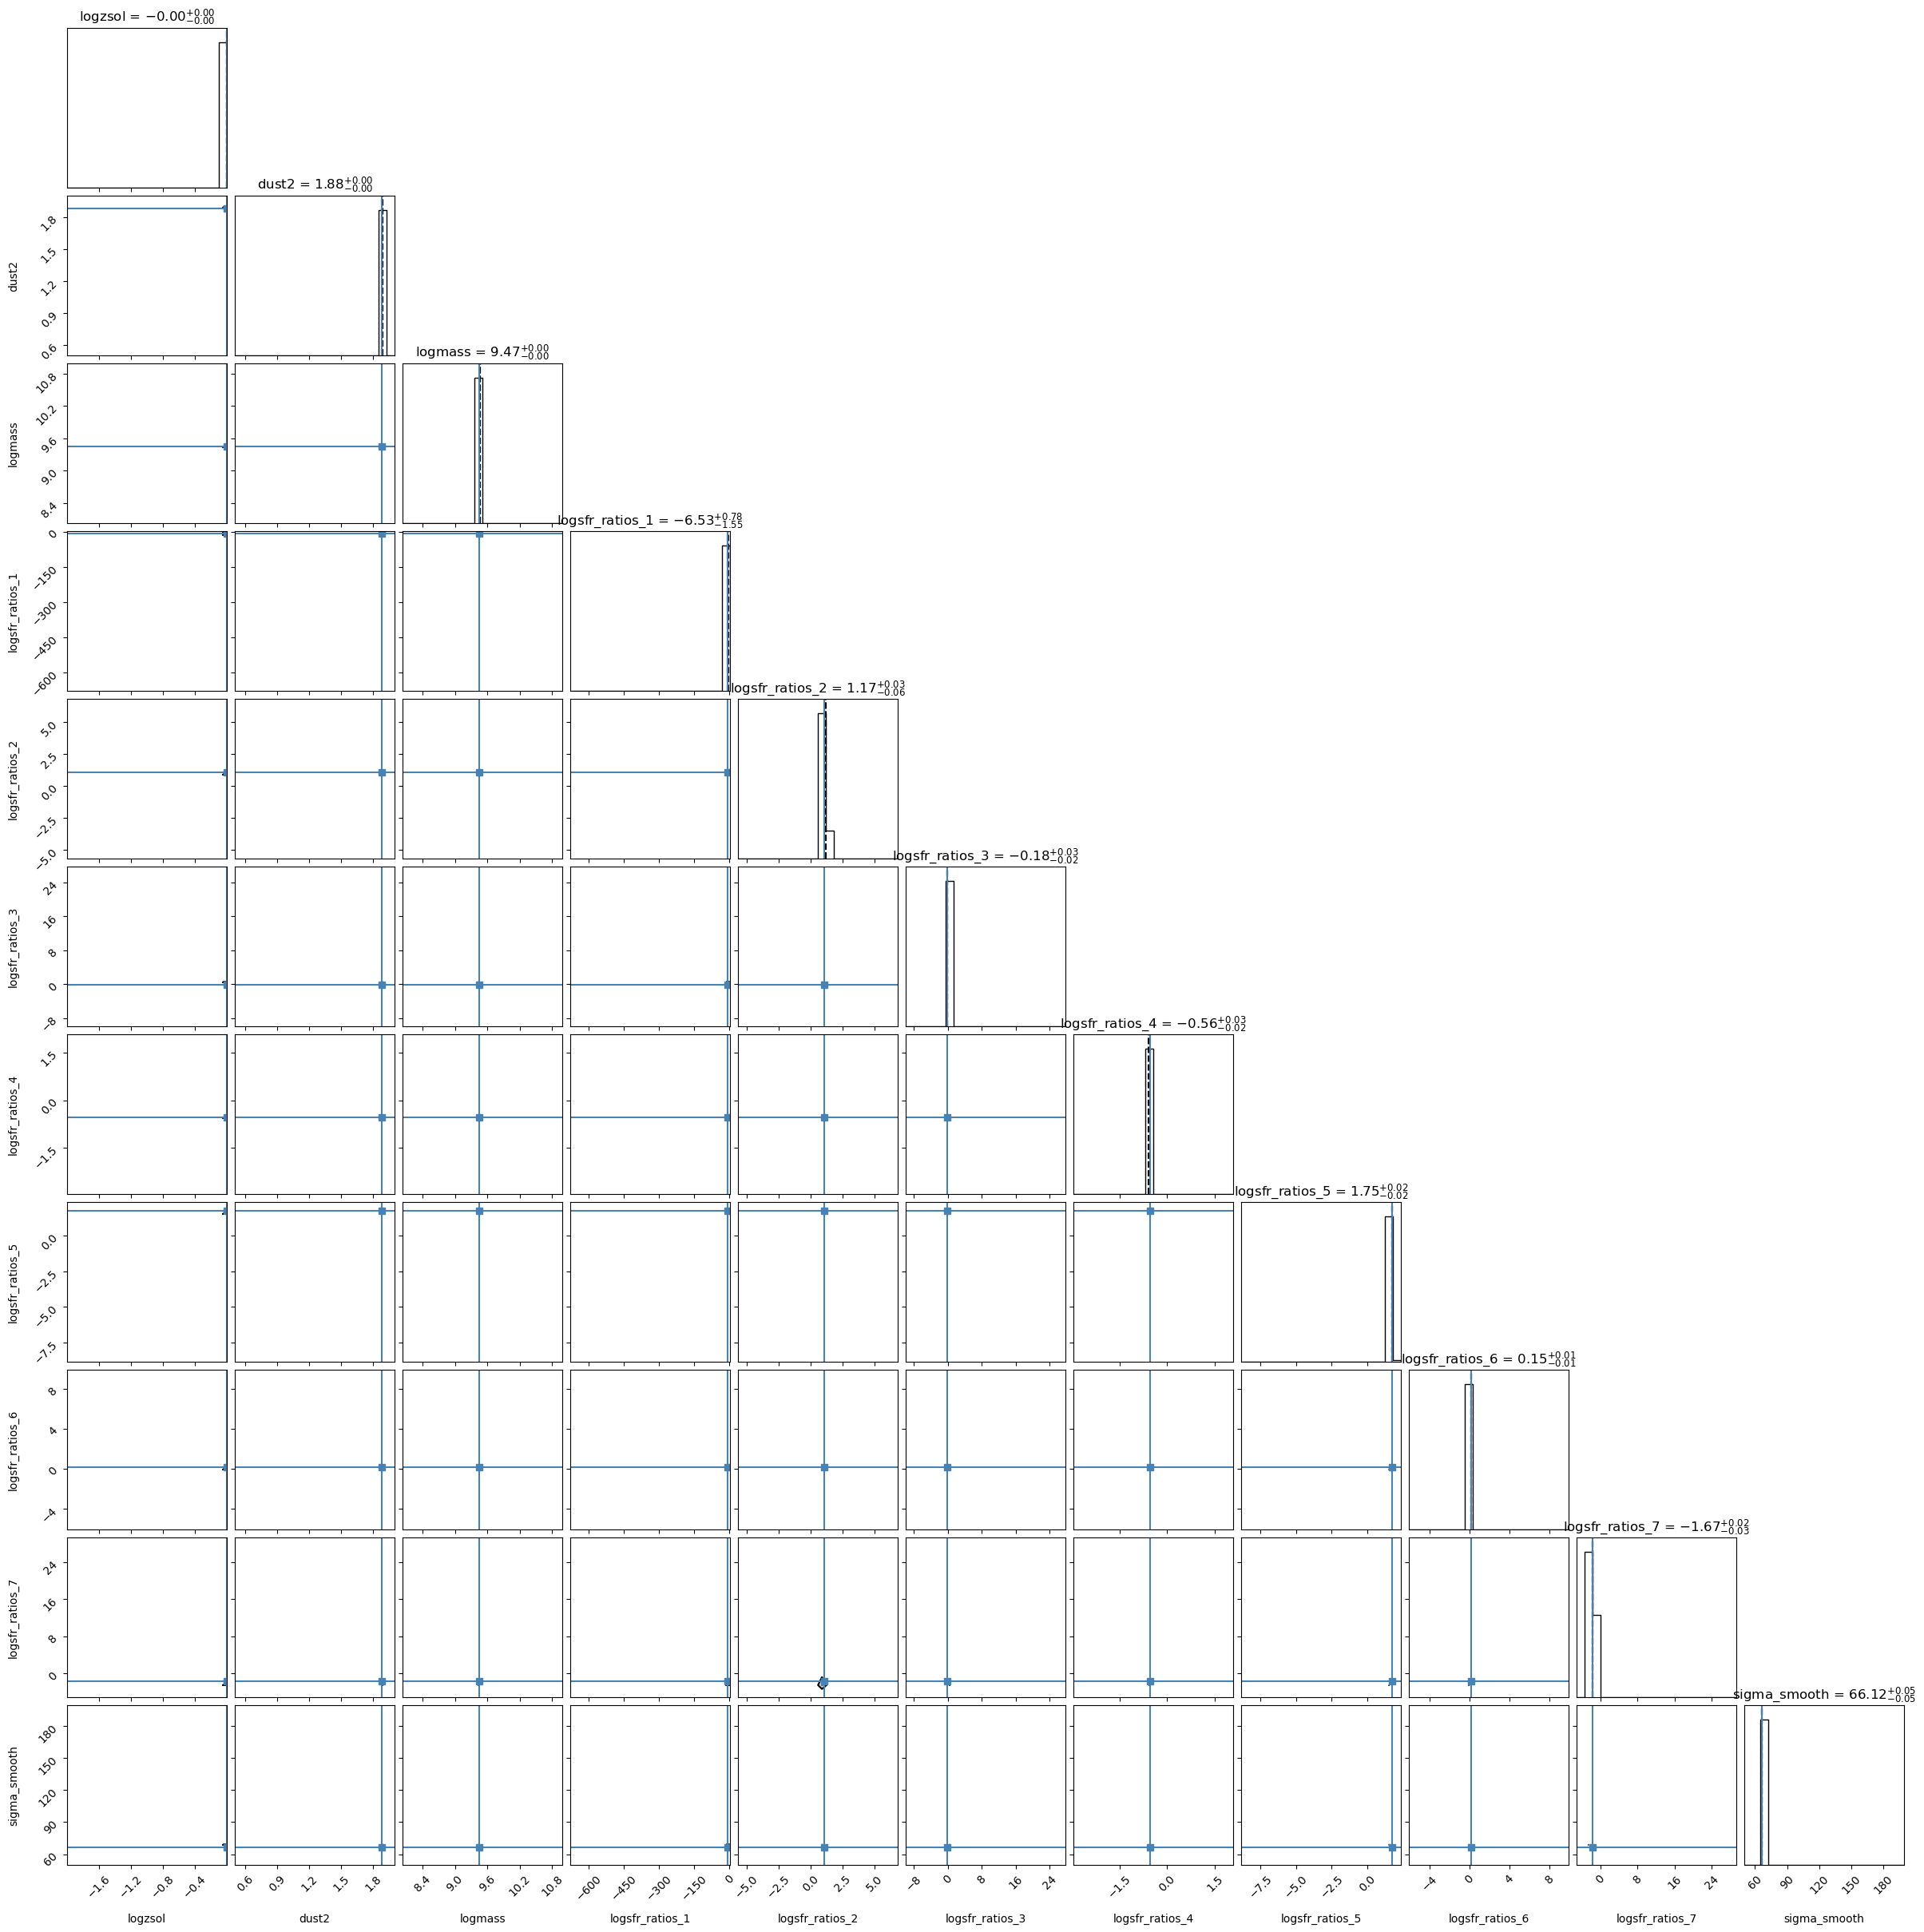

In [91]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
import corner
from dynesty import plotting
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

#print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))

cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best,weight=result.get("weights", None))
                             #fig=plt.subplots(5,5,figsize=(27,27))[0])
#figure = corner.corner(result['chain'], labels=result['theta_labels'],
#                       show_titles=True, title_kwargs={"fontsize": 12})
#plotting.cornerplot(result)

In [11]:
import re
pattern=r"logsfr_ratios_.*"

best_fit={label: value for label, value in zip(theta_labels, theta_best) if (not re.match(pattern, label))}

print(best_fit)

{'logmass': 9.705717908163264}


In [12]:
import re
logsfr_ratios = [value for label, value in zip(theta_labels,theta_best) if re.match(pattern, label)]
best_fit["logsfr_ratios"]=logsfr_ratios

In [13]:
best_fit

{'logmass': 9.705717908163264,
 'logsfr_ratios': [-6.695968394191303,
  5.765018994176138,
  -2.585678649840888,
  -3.0645262976826735,
  7.577035645299773,
  0.049266666712315096,
  -0.09079584499647507]}

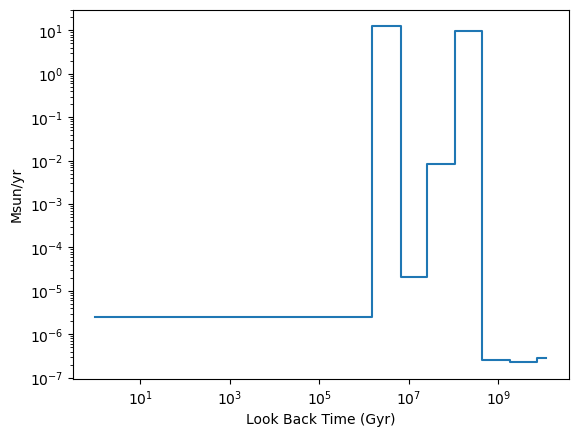

In [14]:
from prospect.plotting import sfh
import pandas as pd

total_mass=10**best_fit["logmass"]
age_bins=10**result["model_params"][8]['init']
age_midpoints = np.mean(age_bins, axis=1)

sfr_ratios = [10**ratio for ratio in best_fit["logsfr_ratios"]]
sfr_values = [0] * (len(sfr_ratios) + 1)
sfr_values[-1] = 1.0
for i in range(len(sfr_ratios) - 1, -1, -1):
    sfr_values[i] = sfr_values[i + 1] * sfr_ratios[i]
bin_widths = age_bins[:, 1] - age_bins[:, 0]
sfr_values = np.array(sfr_values)
sfr_values *= total_mass / np.sum(sfr_values * bin_widths)
#times=np.logspace(-1,1.1336,100)
#times=np.linspace(0.0,13.6,500)
#sfr=sfh.parametric_sfr(times=times,mass=best_fit.loc["mass"].value\
#                       ,dust2=best_fit.loc["dust2"],tage=13.6\
#                       ,tau=best_fit.loc["tau"],fburst=best_fit.loc["fburst"]\
#                      ,fage_burst=best_fit.loc["fage_burst"])
#lookback, sfhs, cmfs=sfh.params_to_sfh(best_fit,agebins=agebins)



#plt.yscale("log")
plt.ylabel("Msun/yr")
plt.xlabel("Look Back Time (Gyr)")
plt.xscale("log")
plt.yscale("log")

plt.step(age_bins[:,0],sfr_values,where="mid")

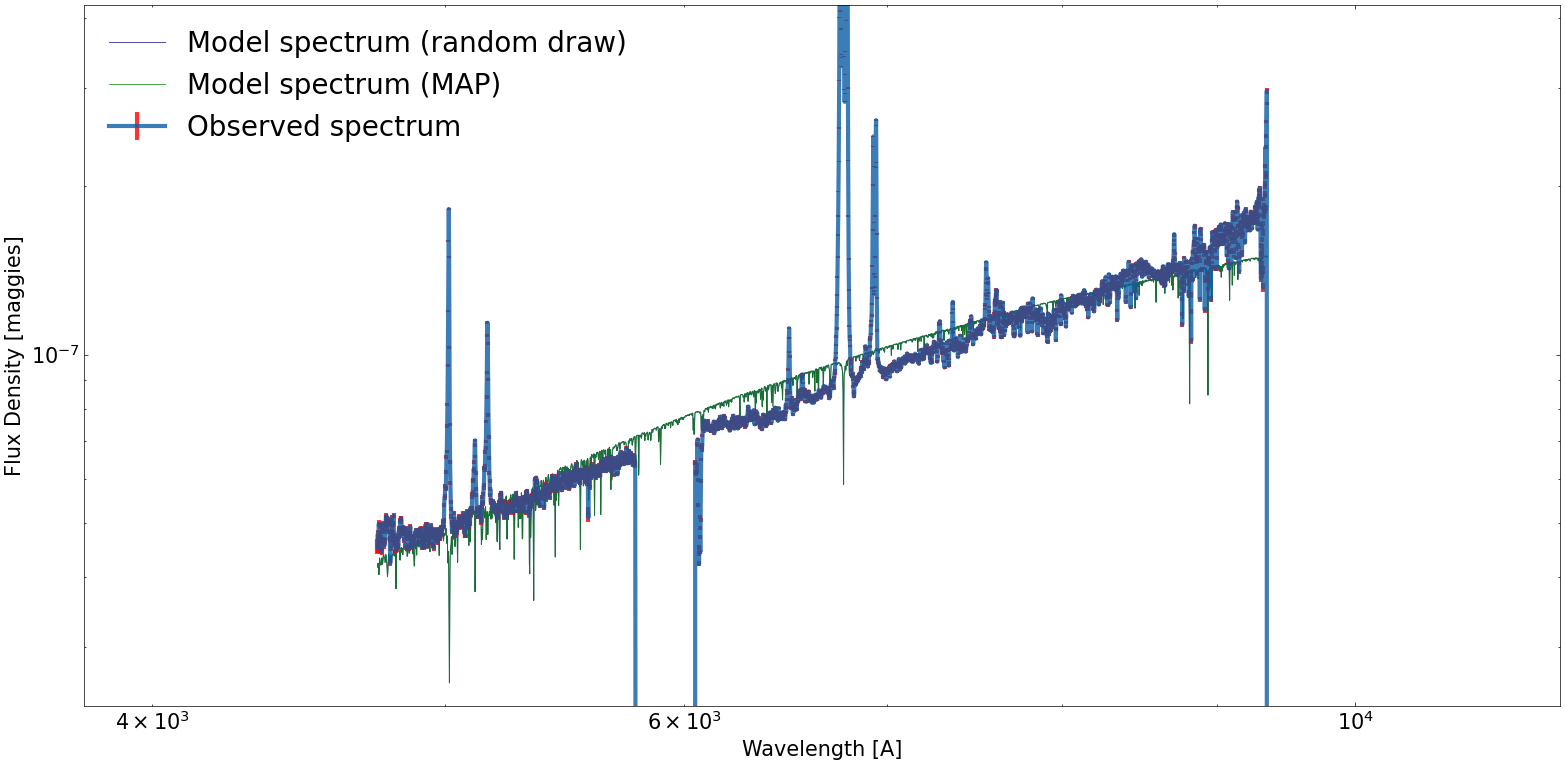

In [150]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)

plt.errorbar(wspec, obs['spectrum'], yerr=obs['unc'], 
         label='Observed spectrum', ecolor='red', 
         ls='-', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

In [16]:
from mpdaf.MUSE import LSF
psname1="UGC"
psname2="2369"
datapath=os.path.join(multiAGNpath,psname1+psname2)

data = np.loadtxt(os.path.join(datapath, "MUSE_1D/{}_nuclear_spec_obj{}.txt".format("MUSE".split("_")[0],obj)))
lam = data[:,0]  # OBS wavelength [A]
flux = data[:,1]*1e-3  # OBS flux [1e-17 erg/s/cm^2/A]
err = data[:,2]*1e-3  # 1 sigma error

lsf = LSF(typ='qsim_v1')
# Extract the LSF (Line Spread Function) data
lsf_fwhm = np.zeros(len(lam))
for nbin,lbda in enumerate(lam):
    lsf_data = lsf.get_LSF(lbda=lbda, step=1.0, size=20) # Mean over spatial axes to get spectral profile
    xspec=np.arange(len(lsf_data))
    g_init = models.Gaussian1D(amplitude=np.max(lsf_data), mean=np.mean(xspec), stddev=2)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, xspec, lsf_data)
    fwhm = g.stddev.value * 2.355
    lsf_fwhm[nbin]=fwhm

# Extract the FWHM from the fitted Gaussian


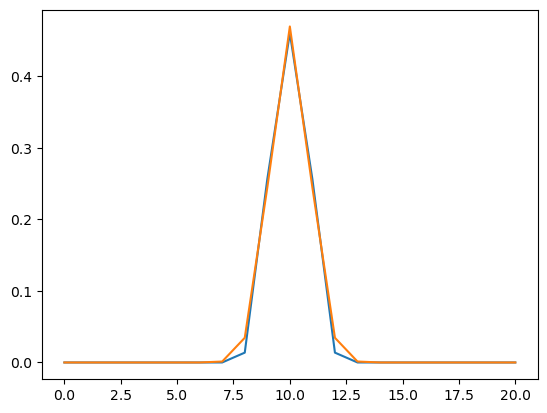

In [14]:
plt.plot(np.arange(len(lsf_data)),lsf_data)
plt.plot(xspec,g(xspec))


In [24]:

np.savetxt("/disk/bifrost/yuanze/multiAGN/UGC2369/gist/configFiles/lsf_MUSE_NFMAO",np.array([lam,lsf_fwhm]).T,fmt="%.4f    %.4f")

In [17]:
result.keys()

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])

array([[ 0.        ,  6.4772    ],
       [ 6.4772    ,  7.        ],
       [ 7.        ,  7.6132279 ],
       [ 7.6132279 ,  8.2264558 ],
       [ 8.2264558 ,  8.8396837 ],
       [ 8.8396837 ,  9.45291159],
       [ 9.45291159, 10.06613949],
       [10.06613949, 10.13672057]])